In [7]:
import torch
import os
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import sys
yolov5_path = "./yolov5"
if yolov5_path not in sys.path:
    sys.path.append(yolov5_path)
from yolov5.utils.loss import ComputeLoss
from yolov5.models.yolo import Model
import yaml

In [8]:
class VehicleDataset(Dataset):
    def __init__(self,image_dir,label_dir,transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
    
    def __len__(self):
        return len(self.image_files)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.image_dir, self.image_files[idx]))
        #Convert color to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        label_path = os.path.join(self.label_dir,self.label_files[idx])

        with open(label_path,"r") as f:
            label_data = f.readlines()

        boxes = []

        for line in label_data:
            split_line = line.strip().split()
            class_id = int(split_line[0])
            x_center, y_center, width, height = map(float, split_line[1:])
            boxes.append([class_id,x_center,y_center,width,height])
        boxes = torch.tensor(boxes,dtype=torch.float32)
        return image, boxes

def display_sample(image, boxes):
    #Displays sample image from dataset
    image = image.permute(1,2,0).numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    h,w, c = image.shape

    for box in boxes:
        class_id, x_center, y_center, width, height = box

        x_center *= w
        y_center *= h
        width *= w
        height *= h
        #Top left corner
        x = x_center - width / 2
        y = y_center - height / 2
        rectangle = patches.Rectangle((x,y),width,height,linewidth=1,edgecolor="g",facecolor="none")
        ax.add_patch(rectangle)
    plt.show()

def collate(batch):
    images = torch.stack([item[0] for item in batch],dim=0)
    targets = [item[1] for item in batch]
    return images, targets

train_images = "Vehicle_Detection_Image_Dataset/train/images"

train_labels = "Vehicle_Detection_Image_Dataset/train/labels"

valid_images = "Vehicle_Detection_Image_Dataset/valid/images"

valid_labels = "Vehicle_Detection_Image_Dataset/valid/labels"
        

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640,640)),
    transforms.ToTensor()

])

train_dataset = VehicleDataset(train_images,train_labels,transform)
train_dataloader = DataLoader(train_dataset,batch_size=5,shuffle=True,collate_fn=collate)

valid_dataset = VehicleDataset(valid_images,valid_labels,transform)
valid_dataloader = DataLoader(valid_dataset,batch_size=5,collate_fn=collate)


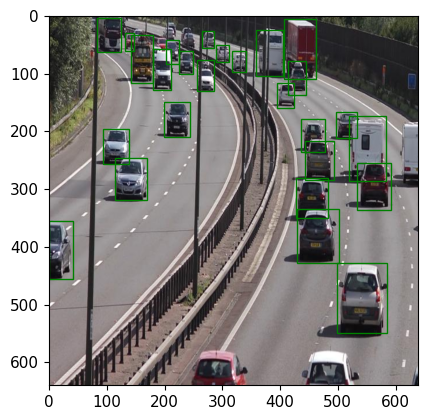

In [9]:
#Example image
display_sample(train_dataset[5][0],train_dataset[5][1])

In [10]:


#model = torch.hub.load("ultralytics/yolov5",'yolov5s',pretrained=True)
model = Model("modified_yolov5s.yaml",ch=3,nc=1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)




                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1   1182720  

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
     

In [14]:

num_epochs = 10
pre_trained = torch.load("yolov5s.pt",map_location=device)
state_dict  = pre_trained["model"].state_dict()

model_state_dict = model.state_dict()

pretrained_dict = {k: v for k, v in state_dict.items() if k in model_state_dict and model_state_dict[k].shape == v.shape}


model.load_state_dict(model_state_dict)

with open("yolov5/data/hyps/hyp.scratch-med.yaml") as f:
    hyp = yaml.safe_load(f)
model.hyp = hyp
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = ComputeLoss(model)
metric = MeanAveragePrecision()


# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_dataloader:
        # Move data to the device
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        targets = []
        for i, label in enumerate(labels):
            label = label.to(device)
            img_ids = torch.full((label.size(0), 1), i, dtype=torch.float32, device=device)
            target = torch.cat((img_ids, label), dim=1)
            targets.append(target)
        targets = torch.cat(targets, dim=0)
        # Forward pass
        outputs = model(images)
        
        # Compute loss
        loss, loss_items = loss_fn(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_loss}")

    # Validation loop
    model.eval()
    metric.reset()
    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.to(device)
            labels = [label.to(device) for label in labels]
            targets = []
            for i, label in enumerate(labels):
                label = label.to(device)
                img_ids = torch.full((label.size(0), 1), i, dtype=torch.float32, device=device)
                target = torch.cat((img_ids, label), dim=1)
                targets.append(target)
            targets = torch.cat(targets, dim=0)
            outputs = model(images)
            print(outputs)
            preds = outputs[0]  # Adjust this according to how your model returns predictions

            metric.update(preds, targets)

    mAP = metric.compute()
    print(f"Epoch [{epoch+1}/{num_epochs}], mAP: {mAP['map']}")

print("Training complete.")




Epoch [1/10], Training Loss: 0.6569664069899807
(tensor([[[3.56664e+00, 3.90250e+00, 8.80634e+00, 1.02894e+01, 7.00270e-04, 9.99983e-01],
         [1.15748e+01, 3.98112e+00, 7.96189e+00, 9.19349e+00, 6.62166e-04, 9.99981e-01],
         [1.98008e+01, 3.96278e+00, 7.65050e+00, 9.05659e+00, 6.59489e-04, 9.99982e-01],
         ...,
         [5.62119e+02, 6.27324e+02, 2.69574e+02, 1.87851e+02, 7.38690e-03, 9.99982e-01],
         [5.90578e+02, 6.25158e+02, 2.93481e+02, 2.49479e+02, 5.05987e-03, 9.99982e-01],
         [6.23948e+02, 6.26830e+02, 3.59642e+02, 2.89652e+02, 4.19842e-03, 9.99981e-01]],

        [[3.71626e+00, 3.93230e+00, 9.00206e+00, 1.06942e+01, 7.09178e-04, 9.99983e-01],
         [1.15969e+01, 3.99067e+00, 8.45258e+00, 1.00785e+01, 7.04151e-04, 9.99982e-01],
         [1.99438e+01, 3.99715e+00, 7.80179e+00, 9.55717e+00, 6.74645e-04, 9.99983e-01],
         ...,
         [5.62183e+02, 6.25707e+02, 1.85860e+02, 1.56742e+02, 1.28896e-02, 9.99983e-01],
         [5.87619e+02, 6.23639e

ValueError: Expected argument `preds` to be of type Sequence, but got tensor([[[3.56664e+00, 3.90250e+00, 8.80634e+00, 1.02894e+01, 7.00270e-04, 9.99983e-01],
         [1.15748e+01, 3.98112e+00, 7.96189e+00, 9.19349e+00, 6.62166e-04, 9.99981e-01],
         [1.98008e+01, 3.96278e+00, 7.65050e+00, 9.05659e+00, 6.59489e-04, 9.99982e-01],
         ...,
         [5.62119e+02, 6.27324e+02, 2.69574e+02, 1.87851e+02, 7.38690e-03, 9.99982e-01],
         [5.90578e+02, 6.25158e+02, 2.93481e+02, 2.49479e+02, 5.05987e-03, 9.99982e-01],
         [6.23948e+02, 6.26830e+02, 3.59642e+02, 2.89652e+02, 4.19842e-03, 9.99981e-01]],

        [[3.71626e+00, 3.93230e+00, 9.00206e+00, 1.06942e+01, 7.09178e-04, 9.99983e-01],
         [1.15969e+01, 3.99067e+00, 8.45258e+00, 1.00785e+01, 7.04151e-04, 9.99982e-01],
         [1.99438e+01, 3.99715e+00, 7.80179e+00, 9.55717e+00, 6.74645e-04, 9.99983e-01],
         ...,
         [5.62183e+02, 6.25707e+02, 1.85860e+02, 1.56742e+02, 1.28896e-02, 9.99983e-01],
         [5.87619e+02, 6.23639e+02, 2.07308e+02, 2.25529e+02, 7.46859e-03, 9.99982e-01],
         [6.23484e+02, 6.26462e+02, 3.26686e+02, 2.81614e+02, 4.31601e-03, 9.99981e-01]],

        [[3.68033e+00, 3.99226e+00, 8.90429e+00, 1.08369e+01, 7.57199e-04, 9.99983e-01],
         [1.17285e+01, 4.03151e+00, 8.45459e+00, 1.00290e+01, 7.52812e-04, 9.99982e-01],
         [1.99076e+01, 4.13154e+00, 8.21505e+00, 1.01422e+01, 7.42951e-04, 9.99983e-01],
         ...,
         [5.62386e+02, 6.26237e+02, 1.93030e+02, 1.69606e+02, 1.14273e-02, 9.99982e-01],
         [5.88052e+02, 6.23429e+02, 2.08835e+02, 2.26436e+02, 7.05870e-03, 9.99982e-01],
         [6.23421e+02, 6.26554e+02, 3.31513e+02, 2.84571e+02, 4.32551e-03, 9.99981e-01]],

        [[3.72149e+00, 3.99399e+00, 8.73088e+00, 1.04207e+01, 6.97299e-04, 9.99983e-01],
         [1.17683e+01, 3.97014e+00, 8.25189e+00, 9.65407e+00, 7.07001e-04, 9.99982e-01],
         [1.97866e+01, 3.97626e+00, 8.10784e+00, 9.30241e+00, 6.97159e-04, 9.99982e-01],
         ...,
         [5.62194e+02, 6.27241e+02, 2.55100e+02, 1.81497e+02, 7.67195e-03, 9.99982e-01],
         [5.90071e+02, 6.24692e+02, 2.75527e+02, 2.42794e+02, 5.22039e-03, 9.99982e-01],
         [6.23762e+02, 6.26567e+02, 3.47162e+02, 2.86246e+02, 4.19670e-03, 9.99981e-01]],

        [[3.70735e+00, 3.97225e+00, 9.08572e+00, 1.09663e+01, 7.29344e-04, 9.99983e-01],
         [1.17034e+01, 4.05315e+00, 8.23409e+00, 9.73332e+00, 7.13190e-04, 9.99982e-01],
         [1.99011e+01, 4.01279e+00, 8.02873e+00, 9.74101e+00, 7.00478e-04, 9.99983e-01],
         ...,
         [5.62841e+02, 6.26398e+02, 2.51552e+02, 1.73544e+02, 6.97063e-03, 9.99982e-01],
         [5.89314e+02, 6.24661e+02, 2.47919e+02, 2.19347e+02, 5.66094e-03, 9.99981e-01],
         [6.23362e+02, 6.26311e+02, 3.15877e+02, 2.83349e+02, 4.06254e-03, 9.99981e-01]]], device='cuda:0')